# Basic Exploratory Data Analysis
## Prerequisites
- Install Python 3



In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load Feature File
df = pd.read_csv("../TeamSeasons.csv")

## Basic Seed Exploration

In [2]:
tourney_teams = df[df['Seed'].notna()]

In [3]:
round_num_map = {
    "Play In": 0,
    "First Round": 1,
    "Second Round": 2,
    "Sweet Sixteen": 3,
    "Elite Eight": 4,
    "Final Four": 5,
    "Championship": 6,
    "Champion": 7
}
tourney_teams["ExitRoundNum"] = tourney_teams["ExitRound"].map(round_num_map)


/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_22657/2435551509.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tourney_teams["ExitRoundNum"] = tourney_teams["ExitRound"].map(round_num_map)


In [18]:
seed_exp_perf = {
    1: 5.75, # Half lose the final four, quarter lose in championship, quarter win the championship
    2: 4, # Make the Elite Eight
    3: 3, 4: 3, # Make the Sweet Sixteen
    5: 2, 6: 2, 7: 2, 8: 2, # Make the Second Round
    9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1 # Lose the First Round
}
seed_historical_perf = {}

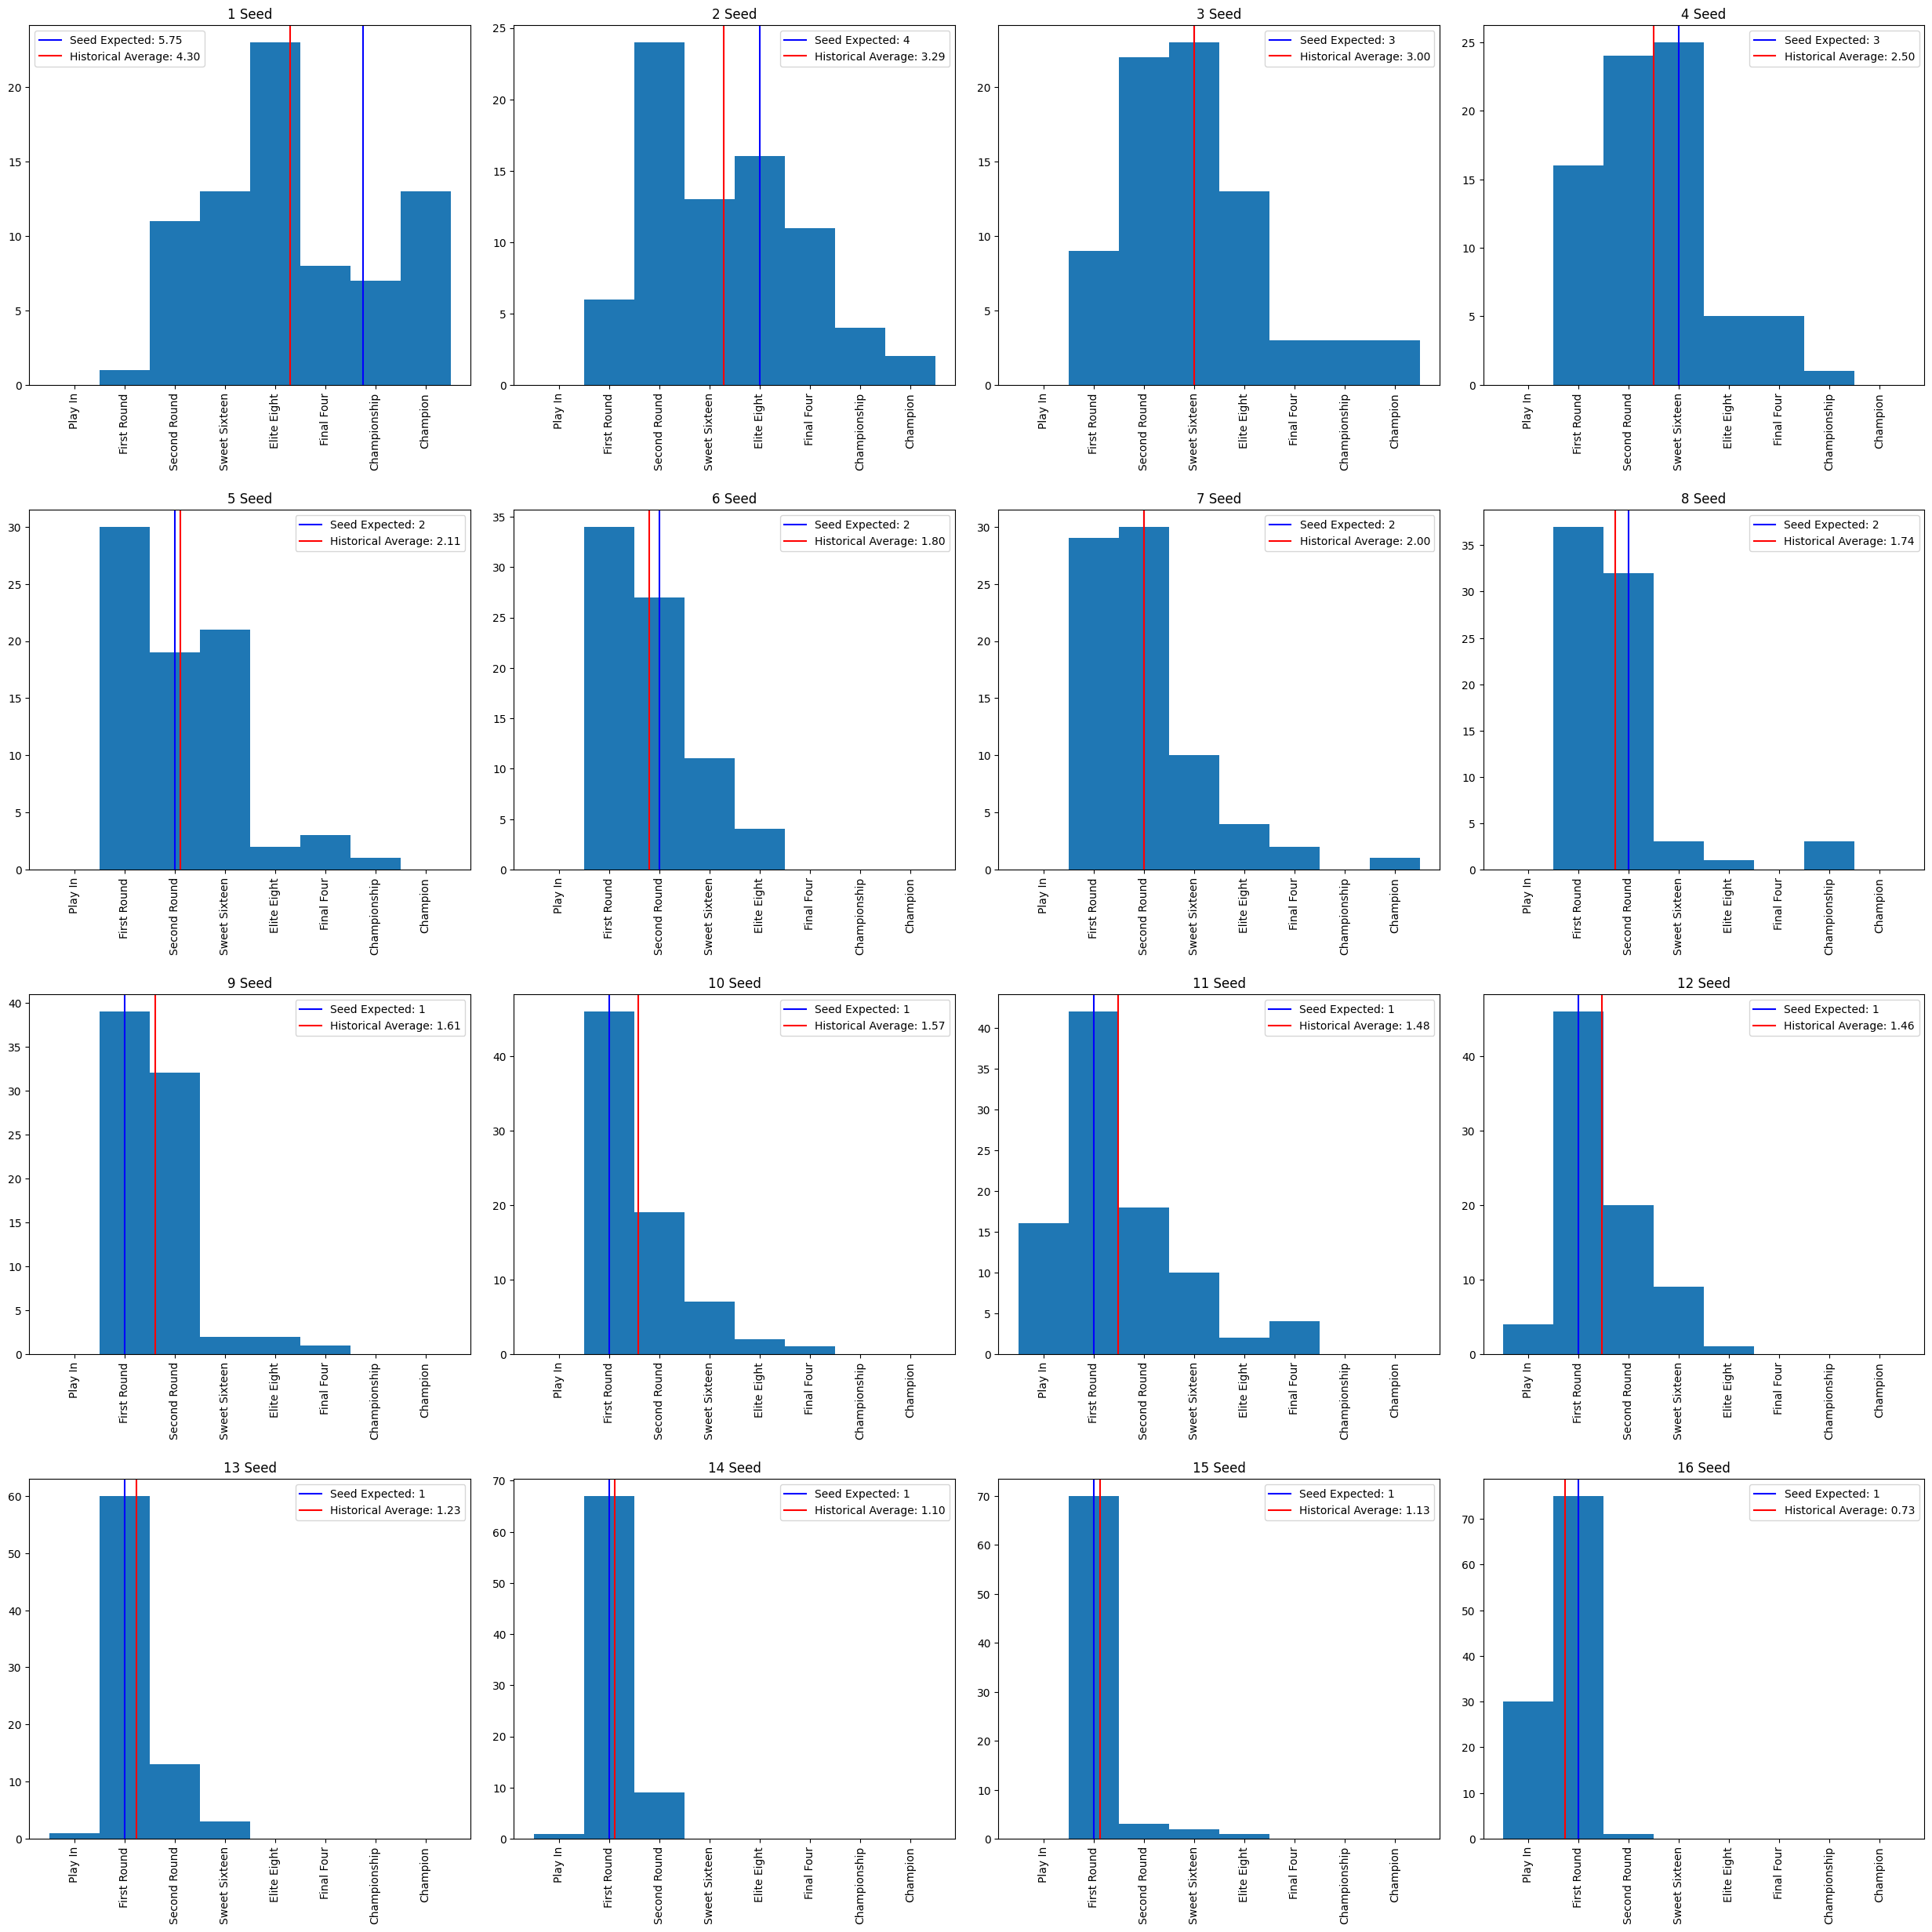

In [19]:
BIN_OFFSET = 0.5
fig, ax = plt.subplots(4, 4, figsize=(25, 25))
ax = ax.flatten()
for seed, seed_df in tourney_teams[["ExitRound", "Seed", "ExitRoundNum"]].groupby("Seed"):
    seed_axis = ax[int(seed) - 1]
    seed_df = seed_df.sort_values(["ExitRoundNum"])
    n, bins, patches = seed_axis.hist(seed_df["ExitRoundNum"], bins=range(0, 9))
    hist_avg = sum([count * rnd for count, rnd in zip(n, bins)]) / sum(n) 
    seed_historical_perf[int(seed)] = hist_avg       
    seed_axis.set_title(f"{int(seed)} Seed")
    seed_axis.axvline(x = seed_exp_perf[int(seed)] + BIN_OFFSET, color = 'b', label = f'Seed Expected: {seed_exp_perf[int(seed)]}')
    seed_axis.axvline(x = hist_avg + BIN_OFFSET, color = 'r', label = f'Historical Average: {hist_avg:.2f}')
    seed_axis.set_xticks(ticks = [p._x0 + BIN_OFFSET for p in patches], labels = round_num_map.keys(), rotation=90)
    seed_axis.legend()
fig.tight_layout(pad = 2)
plt.show()